## Importing the dataset and the neural network classes

In [ ]:
from ipynb.fs.full.Dataset import *
from ipynb.fs.full.Network import *

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import optuna
import os
import time

## Describing the type of analysis and forming the training and validation DataLoaders

In [ ]:
#defining total number of samples in the dataset
n = 100000

#analysis mode:
#Original | top-hat-k | density

analysis_mode = 'original'  #or 'density' or 'top-hat-k'

if analysis_mode == 'original':
    #no augmentations on the maps
    dens_case = 'original'
    dens_cut_str = None
    kmax_cut_str = None

elif analysis_mode == 'density':
    #no change in the fourier domain, but augmentations possible in then pixel density values
    dens_case = 'max'  #or 'min'
    dens_cut_str = '0.5'
    kmax_cut_str = None
    
elif analysis_mode == 'top-hat-k':
    #no change in the pixel density values, but top-hat-k filters are applied on the maps
    dens_case = 'original'
    kmax_cut_str = '0.1'

#original means no cuts on the GDF maps from which P(k) is formed
#max and min mean maximum and minimum density cuts on the maps respectively
case = 'original'

#value of the maximum or minimum density cut. Inconsequential for case = 'original'
dens_case = 'original'
dens_cut_str = None


#If A_true != None, that means that we are forming the whole dataset with a single value of the
#cosmological parameter A = A_true. If it is set as None, the value of A is sampled uniformly in
#the range [0.8,1.2]
A_true = None


#forming the dataset from the data generating class
data_set_train = data_gen(n, 'train', dens_case, dens_cut_str, kmax_cut_str, A_true)
train_dl = DataLoader(dataset=data_set_train, batch_size=128, shuffle=True)
print('Size of train dataset =', data_set_train.__len__())


data_set_valid = data_gen(n, 'valid', dens_case, dens_cut_str, kmax_cut_str, A_true)
valid_dl = DataLoader(dataset=data_set_valid, batch_size=128, shuffle=True)
print('Size of validation dataset =', data_set_valid.__len__())

Size of train dataset = 70000
Size of validation dataset = 15000


## Showing the (Gaussian) distribution of data (all the pixels in all the maps)

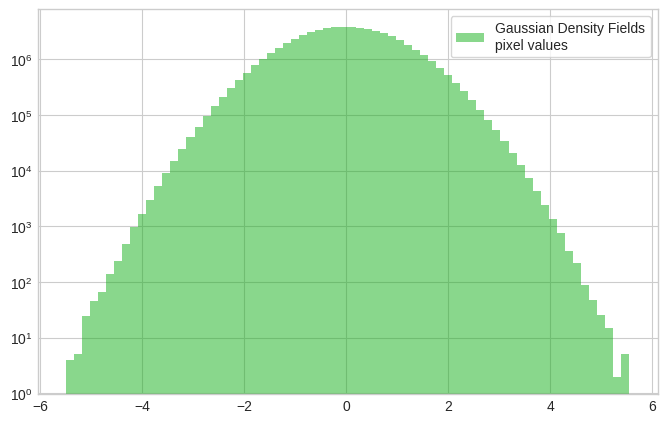

In [ ]:
all_maps = data_set_valid.full_data()
all_maps_flat = all_maps.numpy().flatten()

plt.style.use('default')
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (8,5))
plt.hist(all_maps_flat, bins = 70, alpha = 0.5, color = 'xkcd:green', label = 'Gaussian Density Fields\npixel values')
plt.yscale('log')
plt.legend(frameon = True)
plt.show()

## Visualising one such Gaussian density field

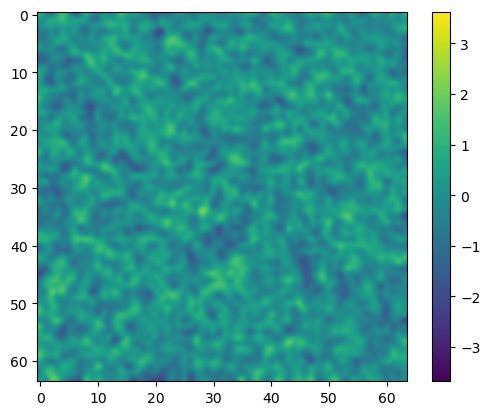

In [ ]:
plt.style.use('default')

for images, labels in valid_dl:
    image = images[10][0,:,:]
    plt.imshow(image, cmap = 'viridis', interpolation = 'bicubic')
    plt.grid(False)
    plt.colorbar()
    break

## Checking for the availability of GPUs

In [ ]:
# use GPUs if available
import torch.backends.cudnn as cudnn

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device1 = torch.device('cpu')
    
    
cudnn.benchmark = True      #May train faster but cost more memory

if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        print("%d GPUs Available"%(torch.cuda.device_count()))
    print('GPU model:',torch.cuda.get_device_name())

else:
    print('Using CPU (Cuda unavailable)\n')
    


Using CUDA
3 GPUs Available
GPU model: Tesla V100-SXM2-32GB


## Describing the folder to save the best model weights, and creating it if not already created

In [ ]:
if analysis_mode == 'original':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}'.format(analysis_mode)
elif analysis_mode == 'density':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}/{}'.format(analysis_mode, dens_case, dens_cut_str)
elif analysis_mode == 'top-hat-k':
    dir_wt = '/mnt/ceph/users/alahiry/gaussian_fields/{}/{}'.format(analysis_mode, kmax_cut_str)
    
if not os.path.exists(dir_wt):
    os.makedirs(dir_wt)  # create folder if it does not exist
    
print('Folder: ' + dir_wt)

Folder: /mnt/ceph/users/alahiry/gaussian_fields/original


## Main training function and _Optuna_ hyperparameter optimisation

### (50 _Optuna_ trials and 200 epochs in each trial)

In [ ]:
def fit(params, epochs, model, train_dl, valid_dl, trial):

    min_valid_loss = 10**34

    lr = params['lr']
    wd = params['wd']
    
    loss_fn = F.mse_loss

    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = lr/100, max_lr = lr*100, cycle_momentum=False)

    for epoch in range(epochs):  # loop over the dataset multiple times
    
        #training model
        train_loss1 = torch.zeros(1).to(device)
        train_loss, counts = 0.0, 0
        model.train()
        
        for images, labels in train_dl:
            bs = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss = loss_fn(preds, labels)
            train_loss1 += loss*bs
            counts += bs
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        train_loss = train_loss1/counts
        train_loss = torch.mean(train_loss).item()

    #evaluating with validation set
    valid_loss1 = torch.zeros(1).to(device)
    valid_loss, counts = 0.0, 0
    model.eval()
    for images, labels in valid_dl:
        with torch.no_grad():
            bs = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss = loss_fn(preds, labels)
            valid_loss1 += loss*bs
            counts += bs
    valid_loss = valid_loss1/counts
    valid_loss = torch.mean(valid_loss).item()

    
    #saving the model if the loss is better(lower) than the previous epoch
    if valid_loss < min_valid_loss:
        fweights = dir_wt + '/weights_{}.pt'.format(trial.number)  
        torch.save(model.state_dict(), fweights)
        min_valid_loss = valid_loss
   
    floss = dir_wt + '/losses_{}.txt'.format(trial.number)  
    #saving epoch, training and validation losses to a text file
    f = open(floss, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
    f.close()

    return min_valid_loss


def objective(trial):

    params = {
            'lr': trial.suggest_float("lr", 1e-6, 5e-3, log=True),
            'wd': trial.suggest_float('wd', 1e-7, 1e-1, log=True),
            'channel_1': trial.suggest_int("channel_1", 4, 20),
            'channel_2': trial.suggest_int("channel_2", 10, 50),
            'channel_3': trial.suggest_int("channel_3", 20, 80),
            'channel_4': trial.suggest_int("channel_4", 30, 200),
            'channel_5': trial.suggest_int("channel_5", 40, 300)
           }

    model = Model_CNN_GDF(params)

    # use GPUs if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    cudnn.benchmark = True      #May train faster but cost more memory


    if (device == torch.device('cuda')):
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        
    model.to(device)
    
    epochs = 200
    best_loss = fit(params,epochs, model, train_dl, valid_dl, trial)

    return best_loss

if case == 'original':
    study_name = 'AstroNone_GDF_{}'.format(case)
    storage    = 'sqlite:///{}/AstroNone_GDF_{}.db'.format(dir_wt, case)
else:
    study_name = 'AstroNone_GDF_{}_{}'.format(case, dens_cut_str)
    storage    = 'sqlite:///{}/AstroNone_GDF_{}_{}.db'.format(dir_wt, case, dens_cut_str)
    
start = time.time()

study = optuna.create_study(direction = "minimize", sampler=optuna.samplers.TPESampler(), study_name = study_name, storage = storage, load_if_exists = True)
study.optimize(objective, n_trials = 51)

stop = time.time()

print('\nTime taken : {:.4f} hrs:'.format((stop-start)/3600.0))